# GOAL
Find the Read Counts per Site (ie Coverage) for a field isolate sWGA, WGS.  How does that relate to GC?  How does that correlate to primer hits?

In [3]:
import os
import os
import glob
import re
import pandas
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



In [32]:
def get_mean_reads_by_gc(pysam_gc_stats_tsv_pattern):
    """
    Find the mean reads across all windows with the same GC content within a sample.
    @param pysam_gc_stats_tsv_pattern str: 
        glob.glob wildcard pattern to find all the pysam stats tsvs for a single sample
    """
    prev_pysam_by_gc_bin = None
    for pysam_gc_stats_tsv in glob.glob(pysam_gc_stats_tsv_pattern):
        display(pysam_gc_stats_tsv)
        pysam_gc = pandas.read_csv(pysam_gc_stats_tsv, sep="\t")
        # Indicate the window start position
        pysam_gc["window"] =  300 * (pysam_gc.pos // 300)

        # Aggregate reads by window
        pysam_by_win = pysam_gc.groupby(["chrom", "window"]).agg({
            'gc': {"gc_win_med": "median", 
                   'gc_win_mean': "mean"},
            'reads_all': {"reads_all_win_med": "median", 
                          'reads_all_win_mean': "mean"},
            'pos': {"win_size": "count"}
        })

        pysam_by_win.columns = pysam_by_win.columns.droplevel()
        
        # Label each window with the ave gc_bin content
        pysam_by_win["gc_bin"] =  pysam_by_win["gc_win_mean"].apply(np.floor)

        # Aggregate by gc_bin.  Weighted average because end windows might be < 300bp.
        # In order to avoid having all pysamstats from all chromosomes in memory,
        # we do a running weighted average.
        pysam_by_win["reads_x_win_size"] = pysam_by_win["reads_all_win_mean"] * pysam_by_win["win_size"]
        
        pysam_by_gc_bin = pysam_by_win.groupby(["gc_bin"]).agg(
            {'reads_x_win_size': {'reads_dot_win_weight': sum},
             'win_size': {'sum_win_weight': sum}})
    
        display(pysam_by_gc_bin.head())
        
        if prev_pysam_by_gc_bin:
            pysam_by_gc_bin = pysam_by_gc_bin + prev_pysam_by_gc_bin
        
        display(pysam_by_gc_bin.head())
        
        prev_pysam_by_gc_bin = pysam_by_gc_bin

    # TODO:  finish me
    return pysam_by_gc_bin

In [33]:
FIELD_SWGA_PYSAMSTATS_GC_TSV_PATTERN = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/pysamstats_gc/*.Pf3D7_1*_v3.pysamstats_gc.txt"
pysam_norm_win_by_gc = get_mean_reads_by_gc(FIELD_SWGA_PYSAMSTATS_GC_TSV)
display(pysam_norm_win_by_gc.shape)
display(pysam_norm_win_by_gc.describe())
display(pysam_norm_win_by_gc.head())

'/Users/tn6/gitrepo/pf_swga_cnv/data/swga.Pf3D7_05_v3.pysamstats.gc.txt'

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,win_size,reads_x_win_size
,sum_win_weight,reads_dot_win_weight
gc_bin,,
1.0,768,4223.0
2.0,227,320.0
3.0,260,428.0
4.0,600,11678.0
5.0,1800,46407.0


,win_size,reads_x_win_size
,sum_win_weight,reads_dot_win_weight
gc_bin,,
1.0,768,4223.0
2.0,227,320.0
3.0,260,428.0
4.0,600,11678.0
5.0,1800,46407.0


(44, 2)

,win_size,reads_x_win_size
,sum_win_weight,reads_dot_win_weight
count,44.000000,4.400000e+01
mean,29938.840909,7.853874e+06
std,32903.041875,1.044658e+07
min,227.000000,3.200000e+02
25%,1703.000000,1.112598e+05
50%,14311.000000,1.564843e+06
75%,58200.000000,1.433386e+07
max,91800.000000,3.194377e+07


,win_size,reads_x_win_size
,sum_win_weight,reads_dot_win_weight
gc_bin,,
1.0,768,4223.0
2.0,227,320.0
3.0,260,428.0
4.0,600,11678.0
5.0,1800,46407.0


In [3]:
def get_norm_gc(pysam_gc_stats_tsv):
    # Per-position GC content, read coverage.  
    # We don't care about properly paired reads here, since there could be 
    # inversions, deletions, insertions that alter orientation of read pairs.
    pysam_gc = pandas.read_csv(pysam_gc_stats_tsv, sep="\t")
    # Indicate the window start position
    pysam_gc["window"] =  300 * (pysam_gc.pos // 300)
    
    # Aggregate reads by window
    pysam_gc_win_field_swga = pysam_gc.groupby("chrom", "window").agg({'gc': {"gc_win_med": "median", 'gc_win_mean': "mean"},
                                              'reads_all': {"reads_all_win_med": "median", 
                                                            'reads_all_win_mean': "mean"}})
    pysam_gc_win_field_swga.columns = pysam_gc_win_field_swga.columns.droplevel()
    # Label each window with the ave gc_bin content
    pysam_gc_win_field_swga["gc_bin"] =  pysam_gc_win_field_swga["gc_win_mean"].apply(np.floor)
    
    # Find the mean reads in each GC Bin
    pysam_gc_per_pos_per_win = pysam_gc.reset_index().set_index("window").join(pysam_gc_win_field_swga[["gc_bin"]])

    pysam_by_gc_bin = pysam_gc_per_pos_per_win.groupby("gc_bin").agg({'reads_all': "mean"})
    pysam_by_gc_bin = pysam_by_gc_bin.rename(columns={'reads_all': 'reads_all_gc_bin_mean'})
    
    pysam_per_win_per_gc_bin = pysam_gc_win_field_swga.reset_index().set_index("gc_bin").join(pysam_by_gc_bin, rsuffix="_median")
    pysam_per_win_per_gc_bin = pysam_per_win_per_gc_bin.reset_index()
    pysam_per_win_per_gc_bin["window"] = pysam_per_win_per_gc_bin["window"].astype(float)
    pysam_per_win_per_gc_bin = pysam_per_win_per_gc_bin.sort_values("window")
    
    pysam_per_win_per_gc_bin["norm_reads_all"] = pysam_per_win_per_gc_bin["reads_all_win_mean"] / pysam_per_win_per_gc_bin["reads_all_gc_bin_mean"]

    
    
    return pysam_per_win_per_gc_bin

# sWGA Coverage Plots

In [4]:
FIELD_SWGA_PYSAMSTATS_GC_TSV = os.path.abspath(os.getcwd() + "/../../data/swga.Pf3D7_05_v3.pysamstats.gc.txt")
FIELD_SWGA_PYSAMSTATS_GC_TSV

'/Users/tn6/gitrepo/pf_swga_cnv/data/swga.Pf3D7_05_v3.pysamstats.gc.txt'

In [5]:
FIELD_WGS_PYSAMSTAT_GC_TSV = os.path.abspath(os.getcwd() + "/../../data/wgs.Pf3D7_05_v3.pysamstats.gc.txt")
FIELD_WGS_PYSAMSTAT_GC_TSV

'/Users/tn6/gitrepo/pf_swga_cnv/data/wgs.Pf3D7_05_v3.pysamstats.gc.txt'

In [6]:
pysam_gc_win_field_swga = get_norm_gc(FIELD_SWGA_PYSAMSTATS_GC_TSV)
display(pysam_gc_win_field_swga.shape)
display(pysam_gc_win_field_swga.describe())
display(pysam_gc_win_field_swga.head())

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


(4405, 8)

,gc_bin,window,reads_all_win_mean,reads_all_win_med,gc_win_mean,gc_win_med,reads_all_gc_bin_mean,norm_reads_all
count,4405.000000,4.405000e+03,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000
mean,18.592963,6.817712e+05,261.507023,261.635528,19.091481,19.086152,261.906028,0.997152
std,5.951881,3.817329e+05,273.069246,274.247315,5.939678,6.060680,79.943694,0.993200
min,1.000000,1.500000e+03,1.000000,1.000000,1.573333,1.000000,1.409692,0.004562
25%,14.000000,3.513000e+05,105.080000,104.000000,14.663333,15.000000,211.965194,0.427512
50%,18.000000,6.819000e+05,184.810000,185.000000,18.846667,19.000000,282.923248,0.709437
75%,22.000000,1.012200e+06,321.793333,322.000000,22.640000,23.000000,328.635241,1.201342
max,46.000000,1.342800e+06,3171.200000,3149.000000,46.883333,50.000000,351.661711,13.243478


,gc_bin,window,reads_all_win_mean,reads_all_win_med,gc_win_mean,gc_win_med,reads_all_gc_bin_mean,norm_reads_all
4288,32.0,1500.0,1.000000,1.0,32.980132,33.0,106.830740,0.009361
4214,30.0,2700.0,1.687023,2.0,30.236641,30.0,131.299209,0.012849
4263,31.0,3000.0,1.000000,1.0,31.181818,31.0,184.671359,0.005415
4264,31.0,4500.0,1.000000,1.0,31.124138,31.0,184.671359,0.005415
4289,32.0,4800.0,1.000000,1.0,32.473684,32.0,106.830740,0.009361


In [7]:
pysam_gc_win_field_wgs = get_norm_gc(FIELD_WGS_PYSAMSTAT_GC_TSV)
display(pysam_gc_win_field_wgs.shape)
display(pysam_gc_win_field_wgs.describe())
display(pysam_gc_win_field_wgs.head())

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


(4473, 8)

,gc_bin,window,reads_all_win_mean,reads_all_win_med,gc_win_mean,gc_win_med,reads_all_gc_bin_mean,norm_reads_all
count,4473.000000,4.473000e+03,4473.000000,4473.000000,4473.000000,4473.000000,4473.000000,4473.000000
mean,18.802146,6.725696e+05,82.663096,82.790409,19.300711,19.298346,82.863411,0.997628
std,6.185524,3.874684e+05,55.177660,55.906787,6.171451,6.286292,43.191683,0.453767
min,1.000000,0.000000e+00,1.000000,1.000000,1.573333,1.000000,3.161677,0.006852
25%,14.000000,3.372000e+05,35.110000,34.000000,14.730000,15.000000,42.672882,0.678111
50%,18.000000,6.726000e+05,73.896667,75.000000,18.956667,19.000000,77.844548,0.956152
75%,22.000000,1.008000e+06,122.843333,124.000000,22.843333,23.000000,119.493385,1.243131
max,47.000000,1.343400e+06,417.610000,375.000000,47.195286,50.000000,169.416667,4.388222


,gc_bin,window,reads_all_win_mean,reads_all_win_med,gc_win_mean,gc_win_med,reads_all_gc_bin_mean,norm_reads_all
4472,47.0,0.0,26.626263,19.0,47.195286,47.0,26.626263,1.000000
4447,39.0,300.0,50.793333,56.0,39.103333,39.0,169.416667,0.299813
4097,28.0,600.0,100.023333,111.5,28.236667,28.0,153.314865,0.652405
3897,26.0,900.0,130.526667,111.5,26.716667,26.0,144.351765,0.904226
4280,31.0,1200.0,175.113333,183.0,31.523333,32.0,132.753515,1.319086


In [10]:
# Taken from https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot


import matplotlib.gridspec as gridspec


class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [28]:
import seaborn as sns; sns.set()

g_swga = sns.jointplot(x=pysam_gc_win_field_swga["gc_win_mean"], 
                       y=pysam_gc_win_field_swga["reads_all_win_mean"], 
                       kind="kde", ylim=(0, 800))
g_swga.fig.suptitle('sWGA')
g_swga.ax_joint.set_xlabel('GC')
g_swga.ax_joint.set_ylabel('swGA Cov')

g_wgs = sns.jointplot(x=pysam_gc_win_field_wgs["gc_win_mean"], 
                      y=pysam_gc_win_field_wgs["reads_all_win_mean"], 
                      kind="kde", ylim=(0, 800))
g_wgs.fig.suptitle('gDNA')
g_wgs.ax_joint.set_xlabel('GC')
g_wgs.ax_joint.set_ylabel('gDNA Cov')

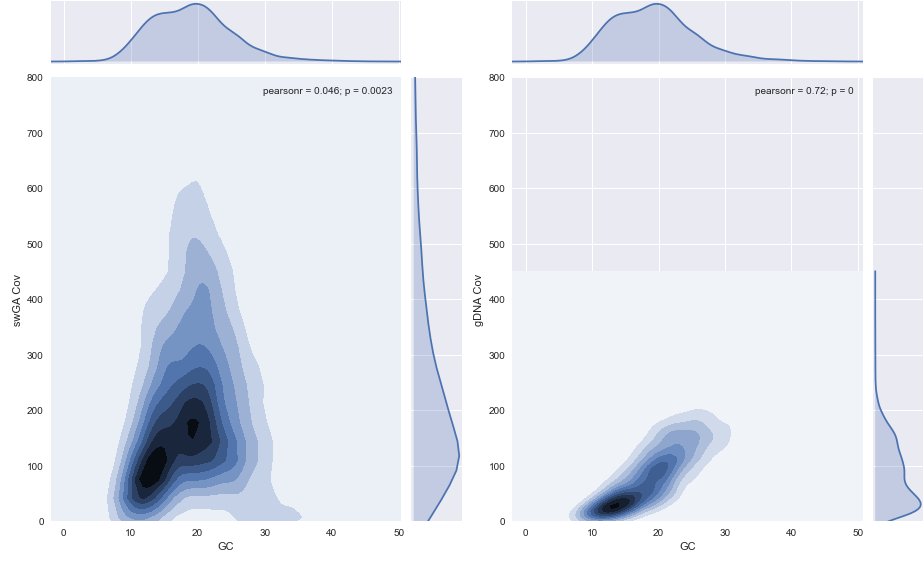

In [29]:
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(g_swga, fig, gs[0])
mg1 = SeabornFig2Grid(g_wgs, fig, gs[1])


gs.tight_layout(fig)

plt.show()

# Correlation Between Read Coverage and Putative Primer Binding Sites for 3D7
We did a simple blat match between primer and 3D7 reference.  Only 100% matches for the entire length of the primers were considered primer binding sites.  No gaps, mismatches allowed.

In [14]:
PRIMER_BINDING_3D7_BED = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/primer_bind_sites/swga_p10_primer.3D7_v3_targets.bed"
primer_sites_3D7 = pandas.read_csv(PRIMER_BINDING_3D7_BED, sep="\t", header=None, names=["chromo", "start", "end"])
primer_sites_3D7 = primer_sites_3D7[primer_sites_3D7["chromo"] == "Pf3D7_05_v3"]
primer_sites_3D7["window"] = 300 * (primer_sites_3D7["start"] // 300)
display(primer_sites_3D7.head())
display(primer_sites_3D7.shape)
display(primer_sites_3D7.describe())

,chromo,start,end,window
769,Pf3D7_05_v3,20123,20486,20100
770,Pf3D7_05_v3,20488,26412,20400
771,Pf3D7_05_v3,26414,28455,26400
772,Pf3D7_05_v3,28457,30868,28200
773,Pf3D7_05_v3,30870,31380,30600


(178, 4)

,start,end,window
count,178.000000,1.780000e+02,178.000000
mean,93460.280899,1.008933e+05,93308.426966
std,44653.441445,1.036196e+05,44647.904232
min,20123.000000,2.048600e+04,20100.000000
25%,59934.250000,6.019200e+04,59775.000000
50%,91321.000000,9.161950e+04,91200.000000
75%,119790.500000,1.207635e+05,119700.000000
max,251901.000000,1.343557e+06,251700.000000


In [15]:
# Count the number of primer binding sites in window
primer_sites_3D7_agg = primer_sites_3D7.groupby("window").agg({"start": "count"})
primer_sites_3D7_agg = primer_sites_3D7.rename(columns={"start": "total_primers"})
display(primer_sites_3D7_agg.head())
display(primer_sites_3D7_agg.shape)
display(primer_sites_3D7_agg.describe())

,chromo,total_primers,end,window
769,Pf3D7_05_v3,20123,20486,20100
770,Pf3D7_05_v3,20488,26412,20400
771,Pf3D7_05_v3,26414,28455,26400
772,Pf3D7_05_v3,28457,30868,28200
773,Pf3D7_05_v3,30870,31380,30600


(178, 4)

,total_primers,end,window
count,178.000000,1.780000e+02,178.000000
mean,93460.280899,1.008933e+05,93308.426966
std,44653.441445,1.036196e+05,44647.904232
min,20123.000000,2.048600e+04,20100.000000
25%,59934.250000,6.019200e+04,59775.000000
50%,91321.000000,9.161950e+04,91200.000000
75%,119790.500000,1.207635e+05,119700.000000
max,251901.000000,1.343557e+06,251700.000000


In [16]:
# Get 3D7 coverage
pf_3d7_swga_gc = get_norm_gc(pysam_gc_stats_tsv=PF_3D7_SWGA_COV_GC_TSV)
display(pf_3d7_swga_gc.head())
display(pf_3d7_swga_gc.shape)
display(pf_3d7_swga_gc.describe())

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,gc_bin,window,reads_all_win_med,reads_all_win_mean,gc_win_med,gc_win_mean,reads_all_gc_bin_mean,norm_reads_all
4422,47.0,0.0,17.0,16.235915,47.0,47.098592,16.235915,1.000000
4405,41.0,300.0,21.0,18.884793,42.0,41.013825,21.163114,0.892345
4293,32.0,3000.0,1.0,1.000000,33.0,32.550000,57.670817,0.017340
4294,32.0,3300.0,1.0,1.000000,33.0,32.910000,57.670817,0.017340
4295,32.0,8100.0,1.0,1.000000,33.0,32.758929,57.670817,0.017340


(4425, 8)

,gc_bin,window,reads_all_win_med,reads_all_win_mean,gc_win_med,gc_win_mean,reads_all_gc_bin_mean,norm_reads_all
count,4425.000000,4.425000e+03,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000
mean,18.668249,6.785835e+05,201.584859,200.976715,19.163955,19.166845,201.287319,0.996217
std,6.102148,3.833047e+05,188.306638,187.043927,6.217507,6.090199,45.651083,0.884475
min,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.573333,1.000000,0.006515
25%,14.000000,3.468000e+05,94.000000,94.133333,15.000000,14.666667,186.514081,0.472136
50%,18.000000,6.786000e+05,151.000000,150.000000,19.000000,18.866667,222.546025,0.760572
75%,22.000000,1.010400e+06,239.000000,239.466667,23.000000,22.690000,225.123660,1.188936
max,51.000000,1.343400e+06,1729.000000,1687.793333,52.000000,51.750000,260.971865,7.154946


In [17]:
cov_primer_3D7 = pf_3d7_swga_gc.reset_index().set_index("window").join(primer_sites_3D7_agg.set_index("window"))

cov_primer_3D7 = cov_primer_3D7[~pandas.isnull(cov_primer_3D7["total_primers"])]
display(cov_primer_3D7.head())
display(cov_primer_3D7.describe())
display(cov_primer_3D7.shape)

,index,gc_bin,reads_all_win_med,reads_all_win_mean,gc_win_med,gc_win_mean,reads_all_gc_bin_mean,norm_reads_all,chromo,total_primers,end
window,,,,,,,,,,,
20100.0,696,13.0,2.0,2.302721,14.0,13.510204,222.546025,0.010347,Pf3D7_05_v3,20123.0,20486.0
20400.0,298,11.0,2.0,2.057239,11.0,11.370370,222.968377,0.009227,Pf3D7_05_v3,20488.0,26412.0
26400.0,43,8.0,30.0,26.260000,6.0,8.210000,234.296667,0.112080,Pf3D7_05_v3,26414.0,28455.0
28200.0,3735,25.0,64.0,63.590000,25.0,25.560000,168.752320,0.376824,Pf3D7_05_v3,28457.0,30868.0
30600.0,3148,22.0,49.0,47.513333,22.0,22.723333,186.514081,0.254744,Pf3D7_05_v3,30870.0,31380.0


,index,gc_bin,reads_all_win_med,reads_all_win_mean,gc_win_med,gc_win_mean,reads_all_gc_bin_mean,norm_reads_all,total_primers,end
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,1.780000e+02
mean,1104.921348,14.129213,277.800562,274.930711,14.466292,14.620921,225.760911,1.216435,93460.280899,1.008933e+05
std,967.869362,4.133389,234.751728,230.692586,4.236509,4.131458,17.161018,1.037817,44653.441445,1.036196e+05
min,20.000000,7.000000,2.000000,2.057239,6.000000,7.976667,168.752320,0.009227,20123.000000,2.048600e+04
25%,312.250000,11.000000,100.000000,101.120000,11.000000,11.381111,218.248443,0.439370,59934.250000,6.019200e+04
50%,727.500000,13.000000,211.000000,212.833333,13.000000,13.535102,222.968377,0.920198,91321.000000,9.161950e+04
75%,1721.000000,17.000000,437.125000,411.113333,17.750000,17.761667,230.052111,1.738436,119790.500000,1.207635e+05
max,3746.000000,25.000000,1337.000000,1303.340000,27.000000,25.853333,260.971865,6.129453,251901.000000,1.343557e+06


(178, 11)

Is there any correlation between raw ave window read counts and total primers in a window for sWGA?

In [18]:
cov_primer_3D7[["reads_all_win_mean", "total_primers"]].corr(method='spearman', min_periods=1)

,reads_all_win_mean,total_primers
reads_all_win_mean,1.000000,0.527804
total_primers,0.527804,1.000000


Is there any correlation between GC normalized window read counts and total primers in a window for sWGA?

In [19]:
cov_primer_3D7[["norm_reads_all", "total_primers"]].corr(method='spearman', min_periods=1)

,norm_reads_all,total_primers
norm_reads_all,1.000000,0.545048
total_primers,0.545048,1.000000


# Correlation Between Primer Hits and Coverage in Field Isolate

We took the consensus sequence of the field isolate but didn't ignore indels.  We then blat the primers in the consensus sequence.  Find the correlation between window coverage and the total primer hits within a window.

**TODO:  the consensus sequence might have indels.  Readjust the coordinates of the consensus sequence to correspond to the field isolate window coordinates, which are with respect to 3D7 reference.  We are getting negative correlations to primer hits!?**

In [20]:
BLAT_FIELD_ISOL_TSV = "../../data/swga.consensus.primerhit.tsv"

In [21]:
primer_sites_field = pandas.read_csv(BLAT_FIELD_ISOL_TSV, sep="\t", 
                             names=["qseqid",  "sseqid", "pident", "length", "mismatch", "gapopen", 
                                    "qstart", "qend", "sstart", "send", "evalue", "bitscore"])
primer_sites_field = primer_sites_field[primer_sites_field["sseqid"] == "Pf3D7_05_v3"]
primer_sites_field["window"] = 300 * (primer_sites_field["sstart"] // 300)
display(primer_sites_field.shape)
display(primer_sites_field.head())
display(primer_sites_field.describe())

(320, 13)

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,window
32,Pf1,Pf3D7_05_v3,100.0,10,0,0,1,10,19493,19502,7300.0,19.0,19200
33,Pf1,Pf3D7_05_v3,100.0,10,0,0,1,10,26427,26436,7300.0,19.0,26400
34,Pf1,Pf3D7_05_v3,100.0,10,0,0,1,10,26722,26731,7300.0,19.0,26700
35,Pf1,Pf3D7_05_v3,100.0,10,0,0,1,10,27023,27032,7300.0,19.0,27000
36,Pf1,Pf3D7_05_v3,100.0,10,0,0,1,10,31714,31723,7300.0,19.0,31500


,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,window
count,320.0,320.000000,320.0,320.0,320.0,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,100.0,10.000000,0.0,0.0,1.0,10.000000,70892.150000,70892.150000,9980.000000,19.000000,70741.875000
std,0.0,0.633446,0.0,0.0,0.0,0.633446,44953.126606,44953.828323,8281.783462,1.266892,44946.645447
min,100.0,9.000000,0.0,0.0,1.0,9.000000,19493.000000,19492.000000,2000.000000,17.000000,19200.000000
25%,100.0,10.000000,0.0,0.0,1.0,10.000000,38149.750000,38139.750000,7300.000000,19.000000,38025.000000
50%,100.0,10.000000,0.0,0.0,1.0,10.000000,50546.500000,50546.000000,7300.000000,19.000000,50400.000000
75%,100.0,10.000000,0.0,0.0,1.0,10.000000,99398.250000,99398.250000,7300.000000,19.000000,99225.000000
max,100.0,11.000000,0.0,0.0,1.0,11.000000,253027.000000,253035.000000,26000.000000,21.000000,252900.000000


In [22]:
# Count the number of primer binding sites in window
primer_sites_field_agg = primer_sites_field.groupby("window").agg({"sstart": "count"})
primer_sites_field_agg = primer_sites_field_agg.rename(columns={"sstart": "total_primers"})
display(primer_sites_field_agg.head())
display(primer_sites_field_agg.shape)
display(primer_sites_field_agg.describe())

,total_primers
window,
19200,1
19500,6
26400,9
26700,3
27000,6


(139, 1)

,total_primers
count,139.000000
mean,2.302158
std,2.165790
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,14.000000


In [23]:
cov_primer_field = pysam_gc_win_field_swga.reset_index().set_index("window").join(
    primer_sites_field_agg.reset_index().set_index("window"))

cov_primer_field = cov_primer_field[~pandas.isnull(cov_primer_field["total_primers"])]
display(cov_primer_field.head())
display(cov_primer_field.describe())
display(cov_primer_field.shape)

,index,gc_bin,reads_all_win_med,reads_all_win_mean,gc_win_med,gc_win_mean,reads_all_gc_bin_mean,norm_reads_all,total_primers
window,,,,,,,,,
19200.0,3731,25.0,3.0,3.337900,25.0,25.552511,282.923248,0.011798,1.0
19500.0,3895,26.0,5.0,4.980159,26.0,26.563492,249.829111,0.019934,6.0
26400.0,41,8.0,34.0,34.790000,6.0,8.210000,76.761384,0.453223,9.0
26700.0,5,4.0,23.0,25.606667,4.0,4.520000,19.463333,1.315636,3.0
27000.0,2553,20.0,85.0,94.643333,22.0,20.546667,351.661711,0.269132,6.0


,index,gc_bin,reads_all_win_med,reads_all_win_mean,gc_win_med,gc_win_mean,reads_all_gc_bin_mean,norm_reads_all,total_primers
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,1196.021583,14.517986,234.687050,235.070777,14.928058,15.027837,229.433949,0.988393,2.302158
std,1050.847811,4.503384,307.868468,305.441541,4.640543,4.501492,85.128398,1.049815,2.165790
min,5.000000,4.000000,3.000000,3.337900,4.000000,4.520000,19.463333,0.011798,1.000000
25%,312.500000,11.000000,50.000000,50.770000,12.000000,11.568333,149.359084,0.295524,1.000000
50%,749.000000,13.000000,115.000000,115.493333,14.000000,13.990000,211.965194,0.591814,2.000000
75%,1946.000000,18.000000,309.750000,310.951667,18.000000,18.281667,304.110484,1.293999,3.000000
max,3895.000000,26.000000,2430.500000,2402.230000,27.000000,26.563492,351.661711,7.000426,14.000000


(139, 9)

Is there any correlation between raw ave window read counts and total primers in a window for sWGA in field isolate?

In [24]:
cov_primer_field[["reads_all_win_mean", "total_primers"]].corr(method='spearman', min_periods=1)

,reads_all_win_mean,total_primers
reads_all_win_mean,1.000000,-0.069303
total_primers,-0.069303,1.000000


Is there any correlation between gc normalized window read counts and total primers in a window for sWGA in field isolate?

In [25]:
cov_primer_field[["norm_reads_all", "total_primers"]].corr(method='spearman', min_periods=1)

,norm_reads_all,total_primers
norm_reads_all,1.000000,-0.070261
total_primers,-0.070261,1.000000
